In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import math
import re

In [2]:
ppt = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/ppt_prism_virginia_data.csv')
tmean = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/tmean_prism_virginia_data.csv')
#forage = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/foraging_quality_pennsylvania_data.csv')
forage = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/tmean_prism_virginia_data.csv')


cols = tmean.columns.tolist()

# create new columns 
new_cols = []
for col in cols:
    if "Forage" in col:
        code = col.split("_")[1]
        number = re.findall(r'\d+', code)[0]
        new_cols.append(number)
    else:
        new_cols.append(col)

new_cols

# rename columns
tmean = tmean.rename(columns=dict(zip(tmean.columns, new_cols)))

# create grid_id column
tmean["grid_id"] = tmean["col"].astype(str) + "_" + tmean["row"].astype(str)

possible_cols = tmean.col.tolist()
possible_rows = tmean.row.tolist()

forage["grid_id"] = forage["col"].astype(str) + "_" + forage["row"].astype(str)

def getGridForageQuality(col, row, year, forage=forage):
    grid_id = str(col) + "_" + str(row)
    try:
        #return forage.query(f" grid_id == '{grid_id}' and year == {year}")['Forage_spring_1km'].values[0]
        return float(forage.query(f" grid_id == '{grid_id}' ")['sprng__'].values[0])
    except:
        return getGridForageQuality(col, row, year + 1)


def getGridForageQuality_vectorized(cols, rows, years,forage=forage):
    # Ensure grid_id is available in the forage DataFrame
    grid_ids = str(cols) + "_" + str(rows)

    # Match grid_id and year across entire DataFrame without looping
    mask = (forage['grid_id'].isin(grid_ids)) & (forage['year'].isin(years))

    # Extract the corresponding forage quality values
    #forage_quality = forage.loc[mask, 'Forage_spring_1km']
    forage_quality = forage.loc[mask, 'spring__']

    return forage_quality

################# tmean data #################

cols = tmean.columns.tolist()

new_cols = []
for col in cols:
    if "PRISM_tmean" in col:
        new_cols.append(col.split("_")[-2])
    else:
        new_cols.append(col)
new_cols

tmean = tmean.rename(columns=dict(zip(tmean.columns, new_cols)))


tmean["grid_id"] = tmean["col"].astype(str) + "_" + tmean["row"].astype(str)

def getTmean(col, row, day, month, year, tmean=tmean):
    '''
    Get temperature data for a given grid cell
    col: int, column number
    row: int, row number
    day: int, day of the month
    month: int, month of the year
    year: int, year
    tmean: pd.DataFrame, temperature data

    output:
    float, temperature in degrees celcius
    '''
    if month < 10:
        month = "0" + str(month)
    if day < 10:
        day = "0" + str(day)
    date = str(year) + "" + str(month) + "" + str(day)
    grid_id = str(col) + "_" + str(row)
    tmean = tmean[tmean["grid_id"] == grid_id][date].values[0]
    return float(tmean)

############### ppt data #################

cols = ppt.columns.tolist()

new_cols = []
for col in cols:
    if "PRISM_ppt" in col:
        new_cols.append(col.split("_")[-2])
    else:
        new_cols.append(col)

ppt = ppt.rename(columns=dict(zip(ppt.columns, new_cols)))

ppt["grid_id"] = ppt["col"].astype(str) + "_" + ppt["row"].astype(str)

def getPpt(col, row, day, month, year, ppt=ppt):
    '''
    Get precipitation data for a given grid cell
    col: int, column number
    row: int, row number
    day: int, day of the month
    month: int, month of the year
    year: int, year
    ppt: pd.DataFrame, precipitation data

    output:
    float, precipitation in mm
    '''
    if month < 10:
        month = "0" + str(month)
    if day < 10:
        day = "0" + str(day)
    date = str(year) + "" + str(month) + "" + str(day)
    grid_id = str(col) + "_" + str(row)
    ppt = ppt[ppt["grid_id"] == grid_id][date].values[0]
    return float(ppt)

In [3]:
################ Modeling ################

In [4]:
#grids = pd.read_csv('/Users/edwardamoah/Documents/Dissertation/Osmia_Pop_Simulation/pennsylvania_prism_grid_points_centre_county.csv')
#grids["grid_id"] = grids["col"].astype(str) + "_" + grids["row"].astype(str)
#grids = grids[["col", "row", "grid_id"]]
#grids

In [5]:
### create a function to get the tmean data between a dates 

# this is the extraction of tmean to calculate emergence for 2023

prepareTmean_dict = {}
def prepareEmergenceTmean(year, tmean=tmean):
    '''
    Prepare tmean for a given year for emergence calculation

    it return the data for tmean from November of the previous year to December of the current year
    '''

    if year in prepareTmean_dict:
        return prepareTmean_dict[year]
    tmean_copy = tmean.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    tmean_11 = tmean_copy.filter(like=f"year_{year-1}11")
    tmean_11['grid_id'] = tmean['grid_id']
    tmean_12 = tmean_copy.filter(like=f"year_{year-1}12")
    tmean_12['grid_id'] = tmean['grid_id']
    tmean_year = tmean_copy.filter(like=f"year_{year}")
    tmean_year['grid_id'] = tmean['grid_id']

    tmean_merge = pd.merge(tmean_11, tmean_12, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_year, on='grid_id')

    #tmean_merge = tmean_year # remove the 11 and 12 months data

    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    prepareTmean_dict[year] = tmean_merge
    
    return tmean_merge

In [6]:
def getEmergence_vector(col, row, year):
    
    dev_threshold = 6.53
    cumulative_threshold = 209

    tmean_merge = prepareEmergenceTmean(year)
    arr_1 =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    arr_2 = arr_1 - dev_threshold
    arr_3 = np.where(arr_2 < 0, 0, arr_2)
    arr_4 = arr_3.cumsum()
    first_element_index = np.argwhere(arr_4 > cumulative_threshold)[0][0]

    emergence = datetime(year-1,11,1) + timedelta(days= int(first_element_index) + 1)
    #emergence = datetime(year,1,1) + timedelta(days= int(first_element_index) + 1)
    return datetime.fromtimestamp(emergence.timestamp())
    #return emergence#.strftime("%Y-%m-%d")

In [7]:
preWinterTmean_dict = {}
def preparePreWinterTmean(year):
    if year in preWinterTmean_dict:
        return preWinterTmean_dict[year]
    
    # copy and rename columns
    tmean_copy = tmean.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    # filter for september and october
    tmean_09 = tmean_copy.filter(like=f"year_{year}09")
    tmean_09['grid_id'] = tmean['grid_id']
    tmean_10 = tmean_copy.filter(like=f"year_{year}10")
    tmean_10['grid_id'] = tmean['grid_id']

    # merge the two dataframes
    tmean_merge = pd.merge(tmean_09, tmean_10, on='grid_id')

    # add col, row and grid_id columns
    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']
    tmean_merge['grid_id'] = tmean['grid_id']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    preWinterTmean_dict[year] = tmean_merge
    
    return tmean_merge

In [8]:
def getPreWinteringMortality_vector(col, row, year, pre_winter_delta=0.0025):

    #dev_threshold = 6.53
    dev_threshold = 15

    tmean_merge = preparePreWinterTmean(year)
    arr_1 =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    arr_2 = arr_1 - dev_threshold
    arr_3 = np.where(arr_2 < 0, 0, arr_2)
   
    count = np.count_nonzero(arr_3 > 0)


    return {
        "mortality": count * pre_winter_delta,
        "dev_days": count,
        "cumulative_degrees": np.sum(arr_3)
    }


In [9]:
# prepare winter temperature data
winterTmean_dict = {}
def prepareWinterTmean(year):
    if year in winterTmean_dict:
        return winterTmean_dict[year]

    # copy and rename columns
    tmean_copy = tmean.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    # filter for November, December and January to June of the next year
    tmean_11 = tmean_copy.filter(like=f"year_{year}11")
    tmean_11['grid_id'] = tmean['grid_id']
    tmean_12 = tmean_copy.filter(like=f"year_{year}12")
    tmean_12['grid_id'] = tmean['grid_id']
    tmean_01 = tmean_copy.filter(like=f"year_{year+1}01")
    tmean_01['grid_id'] = tmean['grid_id']
    tmean_02 = tmean_copy.filter(like=f"year_{year+1}02")
    tmean_02['grid_id'] = tmean['grid_id']
    tmean_03 = tmean_copy.filter(like=f"year_{year+1}03")
    tmean_03['grid_id'] = tmean['grid_id']
    tmean_04 = tmean_copy.filter(like=f"year_{year+1}04")
    tmean_04['grid_id'] = tmean['grid_id']
    tmean_05 = tmean_copy.filter(like=f"year_{year+1}05")
    tmean_05['grid_id'] = tmean['grid_id']
    tmean_06 = tmean_copy.filter(like=f"year_{year+1}06")
    tmean_06['grid_id'] = tmean['grid_id']

    # merge the two dataframes
    tmean_merge = pd.merge(tmean_11, tmean_12, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_01, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_02, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_03, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_04, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_05, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_06, on='grid_id')


    # add col, row and grid_id columns
    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']
    #tmean_merge['grid_id'] = tmean['grid_id']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    winterTmean_dict[year] = tmean_merge
    
    return tmean_merge

In [10]:
def getWinteringTemperature_vector(col,row, year):
    dev_threshold = 6.53
    tmean_merge = prepareWinterTmean(year)
    arr_1 =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    #winter_temp = np.mean(arr_1)

    # filter for the days between November 1 and emergence date
    emergence = getEmergence_vector(col, row, year+1)
    #print(emergence)
    winter_date = datetime(year, 11, 1)
    temps = arr_1[:((emergence - winter_date).days)].tolist()
    winter_temp = np.mean(temps)
    
    if winter_temp > dev_threshold:
        return {
            "winter_temp": winter_temp,
            "mortality": 0.5,
            "temps": temps
        }
    else:
        return {
            "winter_temp": winter_temp,
            "mortality": 0,
            "temps": temps
        }


In [11]:
# prepare winter temperature data
reproductionTmean_dict = {}
def prepareReproductionTmean(year):
    if year in reproductionTmean_dict:
        return reproductionTmean_dict[year]
    
    # copy and rename columns
    tmean_copy = tmean.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    # filter for April, May and June
    tmean_04 = tmean_copy.filter(like=f"year_{year}04")
    tmean_04['grid_id'] = tmean['grid_id']
    tmean_05 = tmean_copy.filter(like=f"year_{year}05")
    tmean_05['grid_id'] = tmean['grid_id']
    tmean_06 = tmean_copy.filter(like=f"year_{year}06")
    tmean_06['grid_id'] = tmean['grid_id']
    tmean_07 = tmean_copy.filter(like=f"year_{year}07")
    tmean_07['grid_id'] = tmean['grid_id']

    

    # merge the two dataframes
    tmean_merge = pd.merge(tmean_04, tmean_05, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_06, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_07, on='grid_id')

    # add col, row and grid_id columns
    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']
    #tmean_merge['grid_id'] = tmean['grid_id']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    reproductionTmean_dict[year] = tmean_merge
    
    return tmean_merge

In [12]:
# prepare winter temperature data
reproductionPpt_dict = {}
def prepareReproductionPpt(year):
    if year in reproductionPpt_dict:
        return reproductionPpt_dict[year]
    
    # copy and rename columns
    tmean_copy = ppt.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    # filter for April, May and June
    tmean_04 = tmean_copy.filter(like=f"year_{year}04")
    tmean_04['grid_id'] = tmean['grid_id']
    tmean_05 = tmean_copy.filter(like=f"year_{year}05")
    tmean_05['grid_id'] = tmean['grid_id']
    tmean_06 = tmean_copy.filter(like=f"year_{year}06")
    tmean_06['grid_id'] = tmean['grid_id']
    

    # merge the two dataframes
    tmean_merge = pd.merge(tmean_04, tmean_05, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_06, on='grid_id')

    # add col, row and grid_id columns
    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']
    #tmean_merge['grid_id'] = tmean['grid_id']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    reproductionPpt_dict[year] = tmean_merge
    
    return tmean_merge

In [13]:
# define vectorize reproduction function

def getSpatiallyExplicitReproduction_vector(col, row, emergence, longevity=22, temperature_threshold=13.9, mating_days=2, precipitation_threshold=5, forage_threshold=0.5):

    starting_date = emergence + timedelta(days=mating_days)

    data_start = datetime(emergence.year, 4, 1)

    forage_quality = getGridForageQuality(col, row, emergence.year)
    if forage_quality < forage_threshold:
        egg_delta = 1
    else:
        egg_delta = 2

    # prepare temperature data
    tmean_merge = prepareReproductionTmean(emergence.year)

    arr_t =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    arr_t1 = arr_t[(emergence - data_start).days + mating_days: (emergence - data_start).days + (longevity)]
    arr_t2 = np.where(arr_t1 >= temperature_threshold, 1, 0)

    # prepare precipitation data
    ppt_merge = prepareReproductionPpt(emergence.year)
    arr_p =  ppt_merge[(ppt_merge['col'] == col) & (ppt_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    arr_p1 = arr_p[(emergence - data_start).days + mating_days: (emergence - data_start).days + (longevity)]
    arr_p2 = np.where(arr_p1 < precipitation_threshold, 1, 0)


    arr_c = arr_t2 & arr_p2

    arr_c.sum()

    eggs = arr_c.sum() * egg_delta
    non_foraging_days = (longevity - mating_days) - arr_c.sum()
    precipitation_effect = (longevity - mating_days) - arr_p2.sum()
    temperature_effect = (longevity - mating_days) - arr_t2.sum()
    temps = arr_t1.tolist()
    ppts = arr_p1.tolist()

    egg_days = []
    for i in range(len(arr_c)):
        if arr_c[i] == 1:
            egg_days.append((starting_date + timedelta(days=i)).strftime("%Y-%m-%d")) 

    return {
        "eggs": eggs,
        "non_foraging_days": non_foraging_days,
        "precipitation_effect": precipitation_effect,
        "temperature_effect": temperature_effect,
        "temps": temps,
        "ppts": ppts,
        "egg_days": egg_days,
        'forage_quality': forage_quality
    }


In [14]:
def getEggLarvaMortality_vector(col, row, emergence, reproduction):
    ldt = 10
    udt = 30
    egg_larva_days = 18
    mortality_delta = 0.1
    tmean_merge = prepareReproductionTmean(emergence.year)
    arr_t =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    data_start = datetime(emergence.year, 4, 1)

    cold_days = []
    hot_days = []
    mortality = []
    for date in reproduction['egg_days']:
        date = datetime.strptime(date, "%Y-%m-%d")
        arr_t1 = arr_t[(date - data_start).days: (date - data_start).days + egg_larva_days]
        arr_t2_h = np.where((arr_t1 <= udt), 0, 1)
        arr_t2_c = np.where((arr_t1 >= ldt) , 0, 1)
        cold_days.append(arr_t2_c.sum())
        hot_days.append(arr_t2_h.sum())
        mortality.append((arr_t2_c.sum() + arr_t2_h.sum()) * mortality_delta)

    mortality = np.mean(mortality)
    if mortality > 1:
        mortality = 1
    
    if len(hot_days) == 0:
        return {
            "mortality": 0,
            "cold_days": 0,
            "hot_days": 0
        }


    return {
        "cold_days": np.mean(cold_days),
        "hot_days": np.mean(hot_days),
        "mortality": mortality
    }


In [15]:
# Emergence Model
import datetime
from datetime import datetime, timedelta

emergence_dict = {}

def getEmergence(col, row, year):
    '''
    Get emergence date for a given grid cell
    col: int, column number
    row: int, row number
    year: int, year

    output:
    datetime.date, emergence date
    '''

    dict_key = str(col) + "_" + str(row) + "_" + str(year)
    if dict_key in emergence_dict:
        return emergence_dict[dict_key]

    # function constants
    thermal_temp = 209 # adam et al
    dev_temp = 6.53 # adam et al


    starting_date = f"{year-1}-11-01" # November 1st of the previous year
    starting_date = datetime.strptime(starting_date, "%Y-%m-%d").date()
    cumulative_degrees = 0.0
    new_date = starting_date

    # determine emergence date
    cumulative_degrees = 0.0
    dev_list = []
    while cumulative_degrees < thermal_temp:
        daily_tmean = getTmean(col, row, new_date.day, new_date.month, new_date.year)
        try:
            if daily_tmean >= dev_temp:
                cumulative_degrees += float(daily_tmean - dev_temp)
                dev_list.append(float(daily_tmean - dev_temp))
            else:
                dev_list.append(0.0)
        except:
            print(col, row, new_date, daily_tmean)
            

        new_date += timedelta(days=1)

    emergence_dict[dict_key] = new_date

    return new_date #, dev_list

In [16]:
# Reproduction Model

reproductive_dict = {}

def getSpatiallyExplicitReproduction(col, row, emergence, longevity=22, temperature_threshold=13.9, mating_days=2, precipitation_threshold=5, forage_threshold=0.5):
    '''
    Get reproduction date for a given grid cell
    col: int, column number
    row: int, row number
    year: int, year
    emergence: datetime.date, emergence date

    output:
    datetime.date, reproduction date
    '''

    # dict_key = str(col) + "_" + str(row) + "_" + emergence.strftime("%Y-%m-%d")
    # if dict_key in reproductive_dict:
    #     return reproductive_dict[dict_key]

    # function constants
    eggs = 0
    egg_delta = 1 # change in eggs per day
     # update starting date
    starting_date = emergence + timedelta(days=mating_days)

    # update egg_delta based on foraging quality
    forage_quality = getGridForageQuality(col, row, starting_date.year)
    if forage_quality < forage_threshold:
        egg_delta = 1
    else:
        egg_delta = 2

    non_foraging_days = 0
    precipitation_effect = 0
    temperature_effect = 0
    temps = []
    ppts = []
    egg_days = []
    
    for i in range(longevity-mating_days):
        # get daily temperature and precipitation
        daily_tmean = getTmean(col, row, starting_date.day, starting_date.month, starting_date.year)
        daily_ppt = getPpt(col, row, starting_date.day, starting_date.month, starting_date.year)

        temps.append(daily_tmean)
        ppts.append(daily_ppt)

        # update eggs
        if daily_tmean >= temperature_threshold and daily_ppt < precipitation_threshold:
            eggs += egg_delta
            egg_days.append(starting_date.strftime("%Y-%m-%d"))
            
        else:
            non_foraging_days += 1
            if daily_tmean < temperature_threshold:
                temperature_effect += 1
            if daily_ppt >= precipitation_threshold:
                precipitation_effect += 1

        # update date
        starting_date += timedelta(days=1)
        

    return_dict = {
        "eggs": eggs,
        "non_foraging_days": non_foraging_days,
        "precipitation_effect": precipitation_effect,
        "temperature_effect": temperature_effect,
        "temps": temps,
        "ppts": ppts,
        "egg_days": egg_days,
        'forage_quality': forage_quality
    }

    # reproductive_dict[dict_key] = return_dict

    return return_dict

In [17]:
# Egg and Larva Mortality Model

def getEggLarvaMortality(col, row, emergence, reproduction, mating_days=2):

    def getEggMortalityProbability(date, tmeans, mortality_delta = 0.1):
        # constants
        ldt = 10 # c
        udt = 30 # c

        prob = 0
        cold_days = 0
        hot_days = 0
        for i in range(18): # 4 egg + 14 larva
            if tmeans[date] < ldt or tmeans[date] > udt:
                prob += mortality_delta
                if tmeans[date] < ldt:
                    cold_days += 1
                if tmeans[date] > udt:
                    hot_days += 1
            date = datetime.strptime(date, "%Y-%m-%d").date()
            date += timedelta(days=1)
            date = date.strftime("%Y-%m-%d")

            

        return {
            "prob": prob,
            "cold_days": cold_days,
            "hot_days": hot_days
        }

    total_dev_days = 38 # days 20 forages + 4 egg + 14 larva

    startdate = emergence + timedelta(days=mating_days)

    tmeans = {}
    for i in range(total_dev_days): # get all the tmeans

        tmeans[startdate.strftime("%Y-%m-%d")] = getTmean(col, row, startdate.day, startdate.month, startdate.year)
        startdate += timedelta(days=1)

    egg_mortalities = []
    cold_days = []
    hot_days = []
    for egg_day in reproduction['egg_days']:
        mortality = getEggMortalityProbability(egg_day, tmeans)
        egg_mortalities.append(mortality['prob'])
        cold_days.append(mortality['cold_days'])
        hot_days.append(mortality['hot_days'])

    egg_mortalities = np.mean(egg_mortalities)
    if egg_mortalities > 1:
        egg_mortalities = 1


    if len(hot_days) == 0:
        return {
            "mortality": 0,
            "cold_days": 0,
            "hot_days": 0
        }

    return {    
        "mortality": egg_mortalities,
        "cold_days": np.mean(cold_days),
        "hot_days": np.mean(hot_days)
    }


In [18]:
# Pre-wintering Mortality Model

def getPreWinteringMortality(col, row, year, pre_winter_delta=0.0025):

    startdate = datetime(year, 9, 1)
    enddate = datetime(year, 11, 1)

    #dev_temp = 6.53
    dev_temp = 15

    mortality = 0
    dev_days = 0
    cumulative_degrees = 0
    
    while startdate < enddate:
        daily_tmean = getTmean(col, row, startdate.day, startdate.month, startdate.year)
        if daily_tmean > dev_temp:
            mortality += pre_winter_delta
            dev_days += 1
            cumulative_degrees += float(daily_tmean - dev_temp)

        startdate += timedelta(days=1)

    return {
        "mortality": mortality,
        "dev_days": dev_days,
        "cumulative_degrees": cumulative_degrees
    }
    

In [19]:
# Wintering Mortality Model

def getWinteringTemperature(col, row, year):
        
        dev_temp = 6.53
    
        startdate = datetime(year, 11, 1)
        #enddate = datetime(year+1, 2, 1)
        try:
            enddate = getEmergence(col, row, year+1)
            enddate = datetime(enddate.year, enddate.month, enddate.day)
        except:
            enddate = datetime(year+1, 2, 1)

        print(enddate)

        temps = []
    
        while startdate < enddate:
            daily_tmean = getTmean(col, row, startdate.day, startdate.month, startdate.year)
            temps.append(daily_tmean)
    
            startdate += timedelta(days=1)
        
        winter_temp = np.mean(temps)

        if winter_temp > dev_temp:
            return {
                "winter_temp": winter_temp,
                "mortality": 0.5,
                "temps" : temps
            }
        else:
            return {
                "winter_temp": winter_temp,
                "mortality": 0,
                "temps" : temps
            }

In [20]:
######################## Run Simulation ################

In [21]:
#years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
#years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
years = [2017]
#years = [2020, 2021, 2022, 2023]
#years = [2016, 2017, 2018, 2019]

In [22]:
grids = tmean[["Lctn_Cd", "col","row","grid_id"]]

In [23]:
grids

,Lctn_Cd,col,row,grid_id
0,ALY,1102,279,1102_279
1,AWR,1128,267,1128_267
2,BIL,1113,276,1113_276
3,BTH,1116,287,1116_287
4,BWB,1160,284,1160_284
5,CBM,1113,286,1113_286
6,CDJ,1118,268,1118_268
7,CMC,1117,282,1117_282
8,CTM,1112,285,1112_285
9,CYM,1126,260,1126_260


In [29]:
def getEmergenceData(col, row, year):
    try:
      return getEmergence_vector(col, row, year)
    except:
        print(col, row, year)
        return getEmergence(col, row, year)

    # return a timestamp for 7th May 2015
    #return datetime.fromtimestamp(1430985600)
    
def getPreWinteringData(col, row, year):
    try:
        return getPreWinteringMortality_vector(col, row, year)
    except:
        print(col, row, year)
        return getPreWinteringMortality(col, row, year)
    
def getWinteringData(col, row, year):
    try:
        return getWinteringTemperature_vector(col, row, year)
    except:
        print(col, row, year)
        return getWinteringTemperature(col, row, year)
    
def getReproductionData(col, row, emergence):
    try:
        return getSpatiallyExplicitReproduction_vector(col, row, emergence, temperature_threshold=9, precipitation_threshold=3)
    except:
        print(col, row, emergence)
        try:
            return getSpatiallyExplicitReproduction(col, row, emergence, temperature_threshold=10, precipitation_threshold=0.5)
        except:
            return None
    
def getEggLarvaMortalityData(col, row, emergence, reproduction):
    try:
        return getEggLarvaMortality_vector(col, row, emergence, reproduction)
    except:
        print(col, row, emergence, reproduction)
        return getEggLarvaMortality(col, row, emergence, reproduction)

In [30]:
col =1102
row =279
year = 2017
getEmergenceData(col, row, year)

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_71429/2105412664.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmean_11['grid_id'] = tmean['grid_id']
/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_71429/2105412664.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmean_12['grid_id'] = tmean['grid_id']
/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_71429/2105412664.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

datetime.datetime(2017, 3, 28, 0, 0)

In [31]:
#getReproductionData(col, row, datetime(2017, 5, 7))

In [32]:
for year in years:
    grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergenceData(x['col'], x['row'], year), axis=1)
    grids[f"reproduction_{year}"] = grids.apply(lambda x: getReproductionData(x['col'], x['row'], x[f"emergence_{year}"]), axis=1)
    # grids[f"egg_larva_mortality_{year}"] = grids.apply(lambda x: getEggLarvaMortalityData(x['col'], x['row'], x[f"emergence_{year}"], x[f"reproduction_{year}"]), axis=1)
    # grids[f"pre_winter_{year}"] = grids.apply(lambda x: getPreWinteringData(x['col'], x['row'], year), axis=1)
    # grids[f"wintering_{year}"] = grids.apply(lambda x: getWinteringData(x['col'], x['row'], year), axis=1)
   

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_71429/3827176934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergenceData(x['col'], x['row'], year), axis=1)
/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_71429/3827176934.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids[f"reproduction_{year}"] = grids.apply(lambda x: getReproductionData(x['col'], x['row'], x[f"emergence_{year}"]), axis=1)


In [33]:
grids

,Lctn_Cd,col,row,grid_id,emergence_2017,reproduction_2017
0,ALY,1102,279,1102_279,2017-03-28,"{'eggs': 0, 'non_foraging_days': 20, 'precipit..."
1,AWR,1128,267,1128_267,2017-03-09,"{'eggs': 32, 'non_foraging_days': 4, 'precipit..."
2,BIL,1113,276,1113_276,2017-03-09,"{'eggs': 15, 'non_foraging_days': 5, 'precipit..."
3,BTH,1116,287,1116_287,2017-02-09,"{'eggs': 26, 'non_foraging_days': 7, 'precipit..."
4,BWB,1160,284,1160_284,2017-02-24,"{'eggs': 16, 'non_foraging_days': 4, 'precipit..."
5,CBM,1113,286,1113_286,2017-02-14,"{'eggs': 24, 'non_foraging_days': 8, 'precipit..."
6,CDJ,1118,268,1118_268,2017-03-09,"{'eggs': 16, 'non_foraging_days': 4, 'precipit..."
7,CMC,1117,282,1117_282,2017-02-10,"{'eggs': 26, 'non_foraging_days': 7, 'precipit..."
8,CTM,1112,285,1112_285,2017-02-21,"{'eggs': 30, 'non_foraging_days': 5, 'precipit..."
9,CYM,1126,260,1126_260,2017-03-29,"{'eggs': 0, 'non_foraging_days': 20, 'precipit..."


(array([20.,  0.,  0., 10.,  5.,  0.,  4., 13.,  2.,  3.]),
 array([ 0. ,  3.8,  7.6, 11.4, 15.2, 19. , 22.8, 26.6, 30.4, 34.2, 38. ]),
 <BarContainer object of 10 artists>)

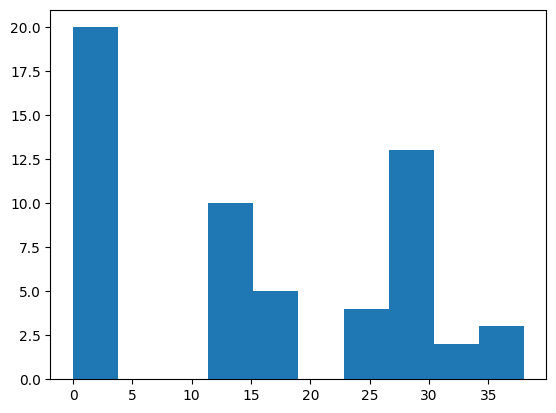

In [35]:
plt.hist([x['eggs'] for x in grids['reproduction_2017']])

In [36]:
grids['eggs'] = [x['eggs'] for x in grids['reproduction_2017']]

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_71429/2980803615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids['eggs'] = [x['eggs'] for x in grids['reproduction_2017']]


In [367]:
sim = grids[['Site','col', 'row', 'grid_id', 'eggs']]

In [368]:
exp = pd.read_csv('/Users/edwardamoah/Documents/GitHub/osmiaBeePop/research/data/Centrella_et_al_Data.csv')

In [369]:
exp['Calendar_Date'] = pd.to_datetime(exp['Calendar_Date'])

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_74112/1987595700.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  exp['Calendar_Date'] = pd.to_datetime(exp['Calendar_Date'])


In [370]:
exp['Emergence'] = '5/7/2015'
exp['Emergence'] = pd.to_datetime(exp['Emergence'])

In [371]:
exp['Final_Date'] = '24/6/2015'
exp['Final_Date'] = pd.to_datetime(exp['Final_Date'])

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_74112/2319756418.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  exp['Final_Date'] = pd.to_datetime(exp['Final_Date'])


In [372]:
exp[exp['Site_Code'] == 'AB']['Calendar_Date'].tolist()

[Timestamp('2015-05-20 00:00:00'),
 Timestamp('2015-05-28 00:00:00'),
 Timestamp('2015-06-03 00:00:00')]

In [373]:
exp['collection_dates'] = exp['Site_Code'].apply(lambda x: exp[exp['Site_Code'] == x]['Calendar_Date'].tolist())

In [374]:
def getForagingDates(calendar_date, emergence, collection_dates):
    
    # find the most recent date just before the calendar date
    early_date = None
    collection_dates = [x for x in collection_dates if x < calendar_date]
    #print(collection_dates)
    if len(collection_dates) > 0:
        early_date = max(collection_dates)
    else:
        early_date = emergence

    #print(early_date, calendar_date)

    # generate a list of dates between early date and calendar date
    foraging_dates = [early_date + timedelta(days=x) for x in range((calendar_date - early_date).days + 1)]

    return foraging_dates
    


In [375]:
exp['foraging_dates'] = exp.apply(lambda x: getForagingDates(x['Calendar_Date'], x['Emergence'], x['collection_dates']), axis=1)

In [376]:
#grids['reproduction_2015'][0]
grids['egg_days'] = [x['egg_days'] for x in grids['reproduction_2015']]
grids['foraging_quality'] = [x['forage_quality'] for x in grids['reproduction_2015']]

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_74112/2751532849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids['egg_days'] = [x['egg_days'] for x in grids['reproduction_2015']]
/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_74112/2751532849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids['foraging_quality'] = [x['forage_quality'] for x in grids['reproduction_2015']]


In [377]:
grids['Site_Code'] = grids['Site']

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_74112/2648138387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids['Site_Code'] = grids['Site']


In [378]:
#exp.columns.tolist()

In [379]:
dt = grids[['Site_Code', 'foraging_quality', 'egg_days']].merge(exp[['foraging_dates', 'Site_Code',  'Total_Emerged_Males','Total_Emerged_Females','Nest_Tubes for_Offspring_Analysis' ]], on='Site_Code')

In [380]:
dt['measured_eggs'] = (dt['Total_Emerged_Males'] + dt['Total_Emerged_Females'])/dt['Nest_Tubes for_Offspring_Analysis']

#dt['measured_eggs'] = (dt['Total_Emerged_Females'])/dt['Nest_Tubes for_Offspring_Analysis']

In [388]:
def getPredictedEggs(egg_days, foraging_dates, foraging_quality):
    foraging_dates = [x.strftime("%Y-%m-%d") for x in foraging_dates]
    num =  len([x for x in egg_days if x in foraging_dates]) 
    if foraging_quality <= 0.4:
        return num * 1
    else:
        return num * 2

In [389]:
dt['predicted_eggs'] = dt.apply(lambda x: getPredictedEggs(x['egg_days'], x['foraging_dates'], x['foraging_quality']), axis=1)

In [390]:
# corr
dt[['measured_eggs', 'predicted_eggs']].corr()

,measured_eggs,predicted_eggs
measured_eggs,1.000000,0.243063
predicted_eggs,0.243063,1.000000


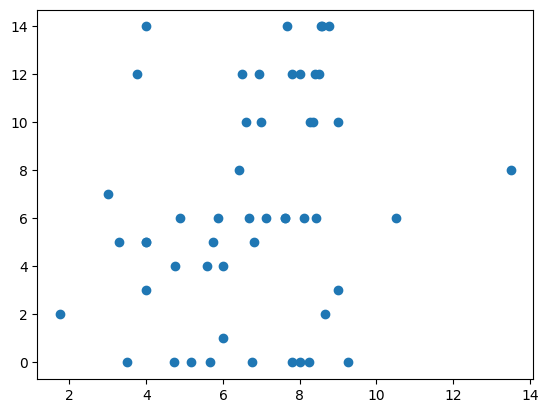

In [391]:
plt.scatter(dt['measured_eggs'], dt['predicted_eggs'])

In [392]:
# compute t test for predicted and measured eggs
from scipy.stats import ttest_ind

ttest_ind(dt['measured_eggs'], dt['predicted_eggs'])

TtestResult(statistic=np.float64(0.4408347222222082), pvalue=np.float64(0.6602842183980488), df=np.float64(100.0))

In [393]:
# calculate r2
from sklearn.metrics import r2_score

r2_score(dt['measured_eggs'], dt['predicted_eggs'])

-3.5031561990744793

In [387]:
'''
def runSimulation(years, grids):
    for year in years:
        #grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergence(x["col"], x["row"], year), axis=1)
        grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergence_vector(x["col"], x["row"], year), axis=1)
        #grids[f"reproduction_{year}"] = grids.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)
        grids[f"reproduction_{year}"] = grids.apply(lambda x: getSpatiallyExplicitReproduction_vector(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)
        grids[f"egg_larva_mortality_{year}"] = grids.apply(lambda x: getEggLarvaMortality_vector(x["col"], x["row"], x[f"emergence_{year}"], x[f"reproduction_{year}"]), axis=1)
        grids[f"pre_winter_mortality_{year}"] = grids.apply(lambda x: getPreWinteringMortality_vector(x["col"], x["row"], year), axis=1)
        grids[f"winter_mortality_{year}"] = grids.apply(lambda x: getWinteringTemperature_vector(x["col"], x["row"], year), axis=1)

    return grids
'''

'\ndef runSimulation(years, grids):\n    for year in years:\n        #grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergence(x["col"], x["row"], year), axis=1)\n        grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergence_vector(x["col"], x["row"], year), axis=1)\n        #grids[f"reproduction_{year}"] = grids.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)\n        grids[f"reproduction_{year}"] = grids.apply(lambda x: getSpatiallyExplicitReproduction_vector(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)\n        grids[f"egg_larva_mortality_{year}"] = grids.apply(lambda x: getEggLarvaMortality_vector(x["col"], x["row"], x[f"emergence_{year}"], x[f"reproduction_{year}"]), axis=1)\n        grids[f"pre_winter_mortality_{year}"] = grids.apply(lambda x: getPreWinteringMortality_vector(x["col"], x["row"], year), axis=1)\n        grids[f"winter_mortality_{year}"] = grids.apply(lambda x: getWinteringTemperature_vec

In [31]:
grids.to_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/osmiaPopModel_python/output/emergence_reproduction_13_9C_5mm_adam_November_1991_2022_all_cyle_november_15c.csv', index=False)

In [32]:
######### spatially explicit simulation #########

In [33]:
### spatially explicit model

'''
grids_sp = forage[["col", "row", "grid_id"]]

for year in years:
    grids_sp[f"emergence_{year}"] = grids_sp.apply(lambda x: getEmergence(x["col"], x["row"], year), axis=1)
    grids_sp[f"reproduction_{year}"] = grids_sp.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)
'''

'\ngrids_sp = forage[["col", "row", "grid_id"]]\n\nfor year in years:\n    grids_sp[f"emergence_{year}"] = grids_sp.apply(lambda x: getEmergence(x["col"], x["row"], year), axis=1)\n    grids_sp[f"reproduction_{year}"] = grids_sp.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)\n'

In [34]:
#grids_sp.to_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/osmiaPopModel_python/output/spatially_explicit_reproduction_with_max_eggs_with_foraging_quality_5mm_precip_threshold_with_temp_and_forage_scores.csv', index=False)

In [35]:
############ Study Sites ################

In [36]:
'''
sites = ['GreenHouse', "Natalie", 'Mendel', 'Lemont']
lat = [40.802, 40.799, 40.884, 40.808]
lon = [-77.862, -77.905, -77.834, -77.82]

df_sites = pd.DataFrame({
    "site": sites,
    "lat": lat,
    "lon": lon
})


df_st = pd.DataFrame({
    "col": [1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131],
    "row": [219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219],
    "year": [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
})

df_st["emergence"] = df_st.apply(lambda x: getEmergence(x["col"], x["row"], x["year"]), axis=1)


#df_st["emergence_date"] = pd.to_datetime(df_st["emergence_date"])
#for year in years:
df_st["reproduction"] = df_st.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence"]), axis=1)


df_st["non_foraging_days"] = [x['non_foraging_days'] for x in df_st["reproduction"].tolist()]
df_st["eggs"] = [x['eggs'] for x in df_st["reproduction"].tolist()]
df_st["precipitation_effect"] = [x['precipitation_effect'] for x in df_st["reproduction"].tolist()]
df_st["temperature_effect"] = [x['temperature_effect'] for x in df_st["reproduction"].tolist()]


def getJulianDay(emergence):
    emergence = datetime.strptime(emergence, '%Y-%m-%d').date()
    starting_date = datetime.strptime(f'{emergence.year}-01-01', '%Y-%m-%d').date()
    return (emergence - starting_date).days + 1


df_st["Julian_day"] = df_st["emergence"].apply(lambda x: getJulianDay(str(x)))
'''

'\nsites = [\'GreenHouse\', "Natalie", \'Mendel\', \'Lemont\']\nlat = [40.802, 40.799, 40.884, 40.808]\nlon = [-77.862, -77.905, -77.834, -77.82]\n\ndf_sites = pd.DataFrame({\n    "site": sites,\n    "lat": lat,\n    "lon": lon\n})\n\n\ndf_st = pd.DataFrame({\n    "col": [1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131],\n    "row": [219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219],\n    "year": [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]\n})\n\ndf_st["emergence"] = df_st.apply(lambda x: getEmergence(x["col"], x["row"], x["year"]), axis=1)\n\n\n#df_st["emergence_date"] = pd.to_datetime(df_st["emergence_date"])\n#for year in years:\ndf_st["reproduction"] = df_st.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence"]), axis=1)\n\n\ndf_st["non_foraging_days"] = [x[\'non_foraging_days\'] for x in df_st["reproduction"].tolist()]\ndf

In [37]:
'''
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame (replace this with your actual DataFrame)
data = {
    'x': [1, 2, 3, 4, 5],
    'y': [2, 3, 5, 4, 6]
}
df = df_st #pd.DataFrame(data)

columns = ['year', 'non_foraging_days', 'eggs', 'precipitation_effect', 'temperature_effect']
# Scatter plot
i=4
plt.scatter(df['year'], df[columns[i]], label='Number of Cold Days')

# Linear regression
coefficients = np.polyfit(df['year'], df[columns[i]], 1)
slope = coefficients[0]
intercept = coefficients[1]
trendline = f'Regression line: y={slope:.2f}x{intercept:.2f}'
plt.plot(df['year'], intercept + slope * df['year'], color='red', label=trendline)

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Days')
plt.title('Number of Cold (<13.9 C) Days vs Year')
plt.legend()

# Show plot
plt.show()
'''

"\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Sample DataFrame (replace this with your actual DataFrame)\ndata = {\n    'x': [1, 2, 3, 4, 5],\n    'y': [2, 3, 5, 4, 6]\n}\ndf = df_st #pd.DataFrame(data)\n\ncolumns = ['year', 'non_foraging_days', 'eggs', 'precipitation_effect', 'temperature_effect']\n# Scatter plot\ni=4\nplt.scatter(df['year'], df[columns[i]], label='Number of Cold Days')\n\n# Linear regression\ncoefficients = np.polyfit(df['year'], df[columns[i]], 1)\nslope = coefficients[0]\nintercept = coefficients[1]\ntrendline = f'Regression line: y={slope:.2f}x{intercept:.2f}'\nplt.plot(df['year'], intercept + slope * df['year'], color='red', label=trendline)\n\n# Add labels and legend\nplt.xlabel('Year')\nplt.ylabel('Days')\nplt.title('Number of Cold (<13.9 C) Days vs Year')\nplt.legend()\n\n# Show plot\nplt.show()\n"

In [38]:
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_st.plot(x='Julian_day', y='temperature_effect', kind='scatter', label='Emergence date')

# Linear regression
coefficients = np.polyfit(df_st['Julian_day'], df_st['temperature_effect'], 1)
slope = coefficients[0]
intercept = coefficients[1]
trendline = f'Regression line: y={slope:.2f}x+{intercept:.2f}'
plt.plot(df_st['Julian_day'], intercept + slope * df_st['Julian_day'], color='red', label=trendline)

# Add labels and legend
plt.xlabel('Julian Date of Emergence')
plt.ylabel('Number of Cold Days')
plt.title('Number of Cold (<13.9 C) Days vs Julian Date of Emergence')
plt.legend()

# Show plot
plt.show()
'''


"\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\n\ndf_st.plot(x='Julian_day', y='temperature_effect', kind='scatter', label='Emergence date')\n\n# Linear regression\ncoefficients = np.polyfit(df_st['Julian_day'], df_st['temperature_effect'], 1)\nslope = coefficients[0]\nintercept = coefficients[1]\ntrendline = f'Regression line: y={slope:.2f}x+{intercept:.2f}'\nplt.plot(df_st['Julian_day'], intercept + slope * df_st['Julian_day'], color='red', label=trendline)\n\n# Add labels and legend\nplt.xlabel('Julian Date of Emergence')\nplt.ylabel('Number of Cold Days')\nplt.title('Number of Cold (<13.9 C) Days vs Julian Date of Emergence')\nplt.legend()\n\n# Show plot\nplt.show()\n"

In [47]:
dic = {'Location_Code': {0: 'ALY',
  1: 'AWR',
  2: 'BIL',
  3: 'BTH',
  4: 'BWB',
  5: 'CBM',
  6: 'CDJ',
  7: 'CMC',
  8: 'CTM',
  9: 'CYM',
  10: 'DWH',
  11: 'GBE',
  12: 'GSD',
  13: 'GTL',
  14: 'HBE',
  15: 'HBT',
  16: 'HCA',
  17: 'HIM',
  18: 'HMH',
  19: 'HPY',
  20: 'IIF',
  21: 'IOO',
  22: 'KID',
  23: 'LER',
  24: 'LHF',
  25: 'LJS',
  26: 'LLB',
  27: 'LLI',
  28: 'LTG',
  29: 'LVA',
  30: 'LYB',
  31: 'MMD',
  32: 'MOL',
  33: 'NRM',
  34: 'NSD',
  35: 'OLS',
  36: 'RTR',
  37: 'SDD',
  38: 'SDN',
  39: 'SGN',
  40: 'SIW',
  41: 'SVN',
  42: 'SWG',
  43: 'TCY',
  44: 'THM',
  45: 'TLW',
  46: 'TMB',
  47: 'TMH',
  48: 'TNT',
  49: 'TOW',
  50: 'TTH',
  51: 'TVM',
  52: 'TVS',
  53: 'TYT',
  54: 'ULG',
  55: 'VIH',
  56: 'WCH',
  57: 'WOS',
  58: 'WOY',
  59: 'WTW',
  60: 'YWM'},
 'nest_id': {0: 135.0,
  1: 154.0,
  2: 145.5,
  3: 161.0,
  4: 115.5,
  5: 67.8,
  6: 45.5,
  7: 101.8,
  8: 94.5,
  9: 153.0,
  10: 127.0,
  11: 112.0,
  12: 112.0,
  13: 142.8,
  14: 145.25,
  15: 108.33333333333333,
  16: 145.5,
  17: 65.0,
  18: 96.16666666666667,
  19: 105.0,
  20: 132.75,
  21: 162.0,
  22: 118.2,
  23: 157.5,
  24: 153.0,
  25: 88.66666666666667,
  26: 75.66666666666667,
  27: 69.5,
  28: 142.0,
  29: 26.0,
  30: 116.5,
  31: 155.0,
  32: 98.0,
  33: 148.0,
  34: 151.0,
  35: 121.0,
  36: 115.25,
  37: 46.5,
  38: 15.0,
  39: 159.25,
  40: 80.0,
  41: 58.5,
  42: 117.25,
  43: 133.0,
  44: 94.5,
  45: 112.66666666666667,
  46: 165.8,
  47: 102.0,
  48: 77.25,
  49: 82.0,
  50: 82.25,
  51: 95.4,
  52: 155.75,
  53: 146.66666666666666,
  54: 180.0,
  55: 88.0,
  56: 49.833333333333336,
  57: 74.0,
  58: 197.0,
  59: 55.833333333333336,
  60: 88.5},
 'size': {0: 8.2,
  1: 10.0,
  2: 5.0,
  3: 10.333333333333334,
  4: 10.25,
  5: 9.2,
  6: 11.5,
  7: 10.4,
  8: 7.333333333333333,
  9: 9.0,
  10: 8.5,
  11: 10.0,
  12: 11.0,
  13: 8.6,
  14: 6.75,
  15: 11.0,
  16: 13.0,
  17: 4.0,
  18: 10.5,
  19: 6.5,
  20: 9.25,
  21: 5.0,
  22: 8.8,
  23: 11.0,
  24: 10.25,
  25: 11.666666666666666,
  26: 5.0,
  27: 14.0,
  28: 12.5,
  29: 19.0,
  30: 10.0,
  31: 11.0,
  32: 12.0,
  33: 8.0,
  34: 7.0,
  35: 9.0,
  36: 13.5,
  37: 7.5,
  38: 12.0,
  39: 6.75,
  40: 17.0,
  41: 11.0,
  42: 9.25,
  43: 10.6,
  44: 5.0,
  45: 8.5,
  46: 8.2,
  47: 10.0,
  48: 8.25,
  49: 22.0,
  50: 10.0,
  51: 11.0,
  52: 10.75,
  53: 10.5,
  54: 6.0,
  55: 6.25,
  56: 9.666666666666666,
  57: 19.0,
  58: 6.0,
  59: 8.5,
  60: 9.0}}

In [48]:
dt = pd.DataFrame(dic)

In [49]:
dt['measured_eggs'] = dt['size']

In [50]:
grids['Location_Code'] = grids['Lctn_Cd']

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_71429/1673564506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids['Location_Code'] = grids['Lctn_Cd']


In [51]:
grids1 = grids.merge(dt, on='Location_Code')

In [52]:
# corr eggs and measured eggs
grids1[['eggs', 'measured_eggs']].corr()

,eggs,measured_eggs
eggs,1.00000,0.03071
measured_eggs,0.03071,1.00000


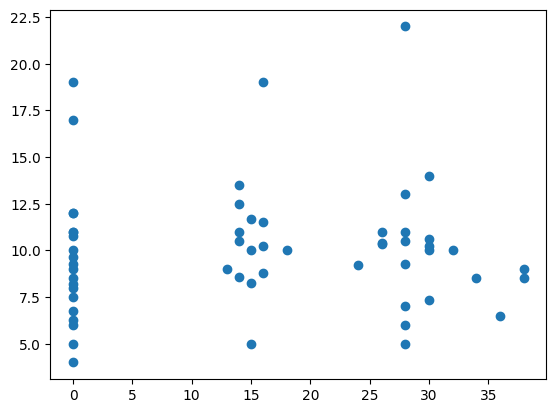

In [53]:
# scatter plot
plt.scatter(grids1['eggs'], grids1['measured_eggs'])